In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import hydra
from modulus.distributed import DistributedManager
from modulus.utils_new.caching import Cache

DistributedManager.initialize()
dist = DistributedManager()

Cache.initialize(dir="/iopsstor/scratch/cscs/stefschu/DSM500/cache")

/iopsstor/scratch/cscs/stefschu/DSM500/github/modulus-a5275d8/modulus/distributed/manager.py:346: UserWarning: Could not initialize using ENV, SLURM or OPENMPI methods. Assuming this is a single process job
  warn(


In [3]:
with hydra.initialize(config_path=".", version_base="1.3"):
    cfg = hydra.compose(config_name="config_new")

In [4]:
from modulus.models_new.graphcast.graph_cast_net_newest import GraphCastNetNew

model = GraphCastNetNew(
    sample_height=cfg.sample.height,
    sample_width=cfg.sample.width,
    sample_channels=cfg.sample.channels,

    include_static_data=cfg.include.static_data,
    include_spatial_info=cfg.include.spatial_info,
    include_temporal_info=cfg.include.temporal_info,
    include_solar_radiation=cfg.include.solar_radiation,
)

In [7]:
import torch
from torch.nn.parallel import DistributedDataParallel

model = model.to(torch.bfloat16).to(dist.device)

# model = DistributedDataParallel(
#     model,
#     device_ids=[0],
#     output_device=dist.device,
#     broadcast_buffers=dist.broadcast_buffers,
#     find_unused_parameters=dist.find_unused_parameters,
#     gradient_as_bucket_view=True,
#     static_graph=True,
# )

In [ ]:
import apex

optimizer = apex.optimizers.FusedAdam(
    model.parameters(),
    lr=cfg.phase1_lr,
    betas=(0.9, 0.95),
    adam_w_mode=True,
    weight_decay=0.1,
)


In [12]:
optimizer

FusedAdam (
Parameter Group 0
    betas: (0.9, 0.95)
    bias_correction: True
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.1
)

In [15]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 1e-06,
   'bias_correction': True,
   'betas': (0.9, 0.95),
   'eps': 1e-08,
   'weight_decay': 0.1,
   'initial_lr': 0.001,
   'params': [0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    34,
    35,
    36,
    37,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
    66,
    67,
    68,
    69,
    70,
    71,
    72,
    73,
    74,
    75,
    76,
    77,
    78,
    79,
    80,
    81,
    82,
    83,
    84,
    85,
    86,
    87,
    88,
    89,
    90,
    91,
    92,
    93,
    94,
    95,
    96,
    97,
    98,
    99,
    100,
    101,
    102,
    103,


In [ ]:
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR, LambdaLR

scheduler = SequentialLR(
    optimizer,
    schedulers=[
        LinearLR(
            optimizer,
            start_factor=1e-3,
            end_factor=1.0,
            total_iters=cfg.phase1_iters,
        ),
        CosineAnnealingLR(
            optimizer,
            T_max=cfg.phase2_iters,
            eta_min=0.0,
        ),
        LambdaLR(
            optimizer,
            lr_lambda=lambda epoch: (cfg.phase3_lr / cfg.phase1_lr),
        ),
    ],
    milestones=[
        cfg.phase1_iters,
        cfg.phase2_iters + cfg.phase3_iters
    ],
)

In [16]:
scheduler.state_dict()

{'_milestones': [1000, 310000],
 'last_epoch': 0,
 '_last_lr': [1e-06],
 '_schedulers': [{'start_factor': 0.001,
   'end_factor': 1.0,
   'total_iters': 1000,
   'base_lrs': [0.001],
   'last_epoch': 0,
   'verbose': False,
   '_step_count': 1,
   '_get_lr_called_within_step': False,
   '_last_lr': [1e-06]},
  {'T_max': 299000,
   'eta_min': 0.0,
   'base_lrs': [0.001],
   'last_epoch': -1,
   'verbose': False,
   '_step_count': 1,
   '_get_lr_called_within_step': False,
   '_last_lr': [1e-06]},
  {'base_lrs': [0.001],
   'last_epoch': -1,
   'verbose': False,
   '_step_count': 1,
   '_get_lr_called_within_step': False,
   '_last_lr': [0.0001],
   'lr_lambdas': [None]}]}

In [17]:
checkpoint_data = torch.load("/iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/checkpoints/model.iter000005.pth", weights_only=True)
checkpoint_data.keys()

dict_keys(['iter', 'training_datapipe_state', 'model', 'optimizer', 'scheduler'])

In [19]:
checkpoint_data["optimizer"]

{'state': {0: {'exp_avg': tensor([[ 1.1778e-03, -4.0039e-05, -1.2626e-03,  ...,  4.1605e-05,
            -5.5868e-04,  1.1780e-04],
           [-1.7597e-04,  8.4496e-04, -4.2995e-03,  ...,  5.5189e-05,
             1.6462e-04,  7.5303e-05],
           [-5.1654e-04,  1.6836e-03,  1.7543e-03,  ..., -7.5920e-05,
             7.1092e-04, -2.0638e-04],
           ...,
           [-1.3373e-03, -1.1694e-03,  1.0911e-03,  ...,  1.1824e-04,
             1.9864e-04, -1.0284e-04],
           [ 5.9675e-04, -6.4016e-04,  8.7215e-04,  ..., -1.0036e-04,
             4.5051e-04, -1.4711e-04],
           [ 1.0136e-03, -5.5130e-04, -1.2408e-03,  ..., -4.0802e-07,
            -2.5943e-04,  4.5049e-05]], device='cuda:0'),
   'exp_avg_sq': tensor([[1.9178e-06, 2.7024e-08, 2.2234e-06,  ..., 7.9389e-08, 4.2886e-07,
            7.1926e-08],
           [5.7559e-08, 9.6123e-07, 2.4908e-05,  ..., 1.2908e-08, 8.2011e-08,
            1.2660e-08],
           [3.6224e-07, 3.8527e-06, 4.1398e-06,  ..., 3.3020e-07, 1.

In [ ]:
from modulus.datapipes.climate.era5_hdf5_newest import ERA5HDF5Datapipe

datapipe = ERA5HDF5Datapipe(
    model=model,
    dataset_base_path=cfg.dataset.base_path,
    dataset_folder="train",
    dataset_samples_per_file=cfg.dataset.samples_per_file,
)

def mapper(data):
    data = data[0]
    input = data["input"]
    output = data["output"]
    
    epoch_idx = data["epoch_idx"].item()
    idx_in_epoch = data["idx_in_epoch"].item()
    global_sample_id = data["global_sample_id"].item()

    return (epoch_idx, idx_in_epoch), global_sample_id
    # )
    # data = {
    #     "epoch_idx": data["epoch_idx"].item(),
    #     "idx_in_epoch": data["idx_in_epoch"].item(),
    #     "global_sample_id": data["global_sample_id"].item(),
    #     #"input": f"{type(input)}, {input.dtype}, {input.shape} {input.device}",
    #     #"output": f"{type(output)}, {output.dtype}, {output.shape} {output.device}",
    #     #"timestamps": data["timestamps"],
    # }
    # return data

def get_max_epoch(results):
    max_epoch = 0
    for result in results:
        for key in result.keys():
            max_epoch = max(max_epoch, key[0])
    return max_epoch

def run_experiment(iterator_offset_epoch_idx=0, iterator_offset_sample_idx=0, epochs=4):
    print("Starting experiment...")
    datapipe = ERA5HDF5Datapipe(
        model=model,

        dataset_base_path=cfg.dataset.base_path,
        dataset_folder="train",
        dataset_samples_per_file=cfg.dataset.samples_per_file,

        iterator_offset_epoch_idx=iterator_offset_epoch_idx,
        iterator_offset_sample_idx=iterator_offset_sample_idx
    )

    results = dict()
    for epoch in range(epochs):
        for i, data in enumerate(datapipe):
            key, value = mapper(data)
            results[key] = value

    return results

experiments = [
    run_experiment(epochs=5),
    run_experiment(iterator_offset_epoch_idx=4, epochs=3),
    run_experiment(iterator_offset_epoch_idx=2, iterator_offset_sample_idx=2, epochs=4),
    run_experiment(iterator_offset_epoch_idx=1, iterator_offset_sample_idx=3, epochs=7),
    run_experiment(iterator_offset_epoch_idx=3, iterator_offset_sample_idx=4, epochs=7),
    run_experiment(iterator_offset_sample_idx=3, epochs=4),
]

for epoch in range(1, get_max_epoch(experiments)):
    for iter in range(len(datapipe)):
        print(f"Epoch {epoch}, Iteration {iter}: ", end="")
        for result in experiments:
            key = (epoch, iter)
            if key in result:
                print(f"{result[key]:4}", end="")
            else:
                print(" "*4, end="")
        print()
    print("-" * 80)



Starting experiment...
Starting experiment...
Starting experiment...
Starting experiment...
Starting experiment...
Starting experiment...
Epoch 1, Iteration 0:    8                   8
Epoch 1, Iteration 1:    4                   4
Epoch 1, Iteration 2:    7                   7
Epoch 1, Iteration 3:    0           0       0
Epoch 1, Iteration 4:    1           1       1
Epoch 1, Iteration 5:                         
Epoch 1, Iteration 6:                         
Epoch 1, Iteration 7:                         
Epoch 1, Iteration 8:                         
Epoch 1, Iteration 9:                         
--------------------------------------------------------------------------------
Epoch 2, Iteration 0:    2           2       2
Epoch 2, Iteration 1:    0           0       0
Epoch 2, Iteration 2:    7       7   7       7
Epoch 2, Iteration 3:    6       6   6       6
Epoch 2, Iteration 4:    9       9   9       9
Epoch 2, Iteration 5:                         
Epoch 2, Iteration 6:        

In [6]:
from modulus.datapipes.climate.era5_hdf5_newest import ERA5HDF5Datapipe

datapipe = ERA5HDF5Datapipe(
    model=model,
    num_output_steps=5,

    dataset_base_path=cfg.dataset.base_path,
    dataset_folder="train",
    dataset_samples_per_file=cfg.dataset.samples_per_file,

    iterator_offset_epoch_idx=0,
    iterator_offset_sample_idx=0
)

for i, data in enumerate(datapipe):
    break

In [7]:
data = data[0]

In [8]:
def get_device(d):
    return d.device if hasattr(d, "device") else "N/A"

for key in data.keys():
    print(f"{key}: {data[key].shape} {data[key].dtype} {type(data[key])} {get_device(data[key])}")

timestamps: torch.Size([1, 6]) torch.int32 <class 'torch.Tensor'> cpu
global_sample_id: torch.Size([1]) torch.int32 <class 'torch.Tensor'> cpu
idx_in_epoch: torch.Size([1]) torch.int32 <class 'torch.Tensor'> cpu
output: torch.Size([1, 5, 31, 721, 1440]) torch.float32 <class 'torch.Tensor'> cuda:0
epoch_idx: torch.Size([1]) torch.int32 <class 'torch.Tensor'> cpu
input: torch.Size([1, 1, 31, 721, 1440]) torch.float32 <class 'torch.Tensor'> cuda:0


In [23]:
d = data["output"].cpu().numpy()
d.shape

(1, 5, 31, 721, 1440)

In [26]:
d = d.squeeze()

In [41]:
# show mean and std per channel
for c in range(31):
    print(f"Channel {c:2}: mean={d[:, c].mean():-10.4}, std={d[:, c].std():-8.4}")

Channel  0: mean=  -0.03974, std=   1.016
Channel  1: mean=   0.06414, std=   1.054
Channel  2: mean=    0.1018, std=  0.9912
Channel  3: mean= 0.0001913, std=   1.012
Channel  4: mean= -0.007347, std=  0.9439
Channel  5: mean=    0.1083, std=  0.9916
Channel  6: mean=  -0.03486, std=   1.017
Channel  7: mean=   0.05899, std=   1.053
Channel  8: mean= -0.005282, std=  0.9663
Channel  9: mean=  -0.03046, std=   1.025
Channel 10: mean=   0.03774, std=   1.033
Channel 11: mean=   0.06131, std=  0.9946
Channel 12: mean=  -0.04941, std=  0.9746
Channel 13: mean=  0.003139, std=   1.003
Channel 14: mean=   0.09628, std=  0.9668
Channel 15: mean=   0.09812, std=   0.934
Channel 16: mean=   0.04918, std=    1.19
Channel 17: mean=  -0.01034, std=   1.007
Channel 18: mean=  -0.02781, std=  0.9664
Channel 19: mean=   0.08424, std=  0.9887
Channel 20: mean=    0.0584, std=   1.016
Channel 21: mean=  -6.8e-08, std=     1.0
Channel 22: mean= -2.54e-08, std=     1.0
Channel 23: mean=-1.938e-08, std= 

In [ ]:
d[0, :, 27:].mean(axis=(2, 3))

(5, 4)

In [22]:
d[0, :, 27:].mean(axis=(2, 3))

array([[ 2.3872769e-01, -9.7108507e-01,  0.0000000e+00,  1.0000000e+00],
       [ 2.3455809e-01, -9.7210091e-01,  1.0000000e+00,  6.1232382e-17],
       [ 2.3038344e-01, -9.7309911e-01,  1.2246476e-16, -1.0000000e+00],
       [ 2.2620569e-01, -9.7408104e-01, -1.0000000e+00, -1.8369724e-16],
       [ 2.2202297e-01, -9.7504264e-01,  0.0000000e+00,  1.0000000e+00]],
      dtype=float32)

(1, 1, 31, 721, 1440)


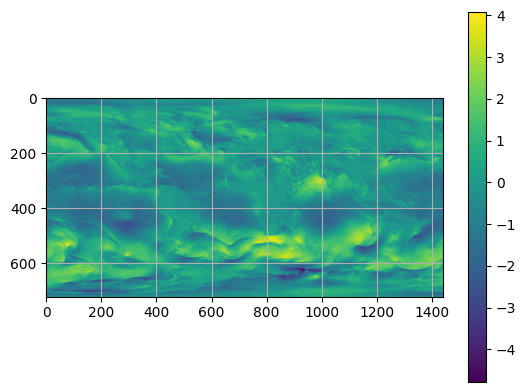

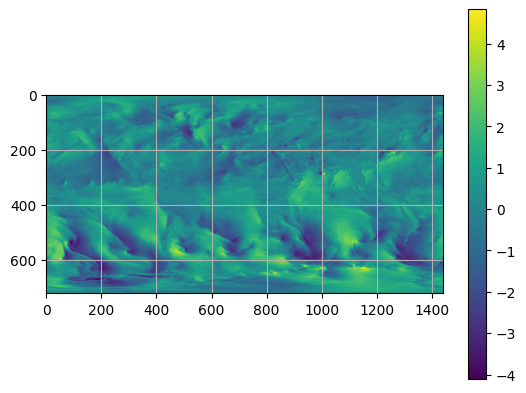

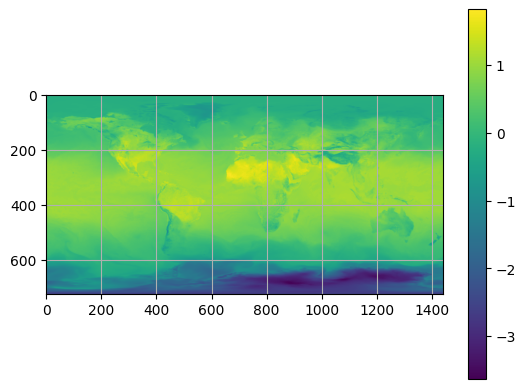

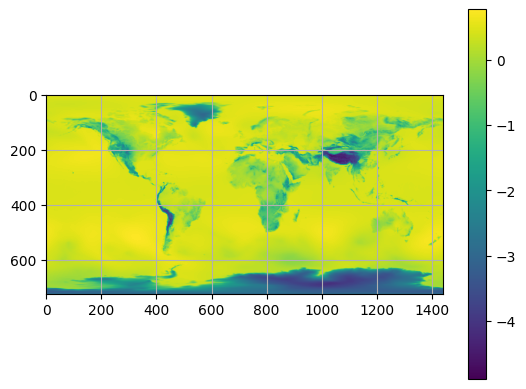

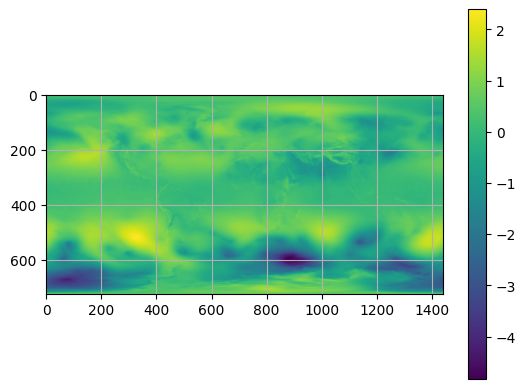

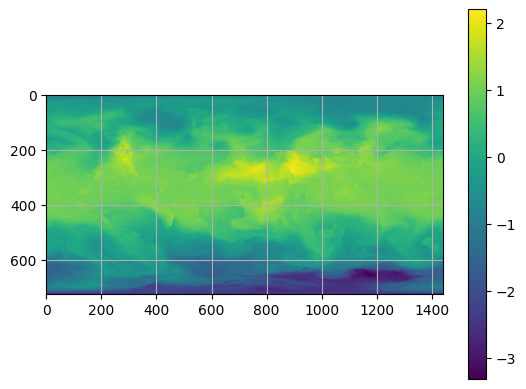

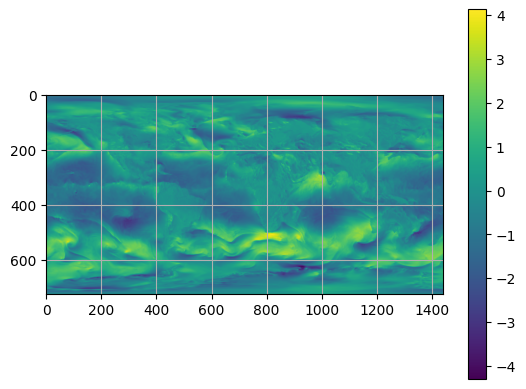

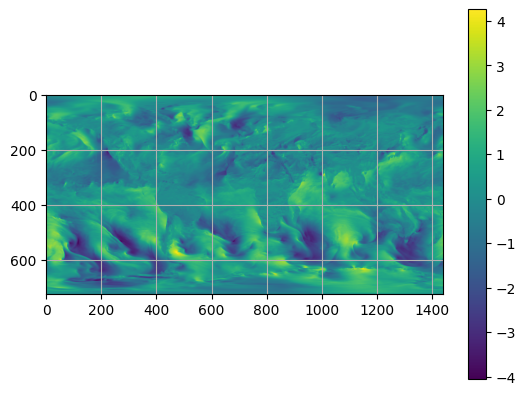

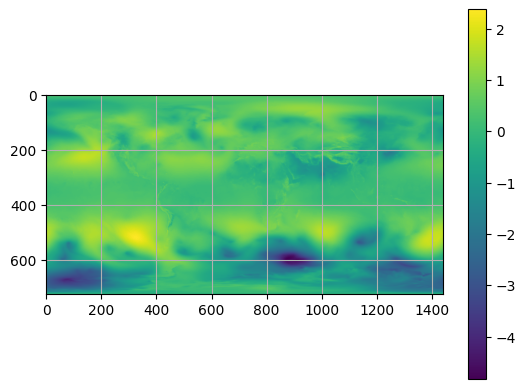

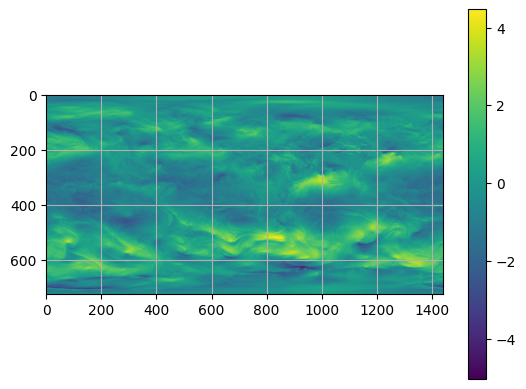

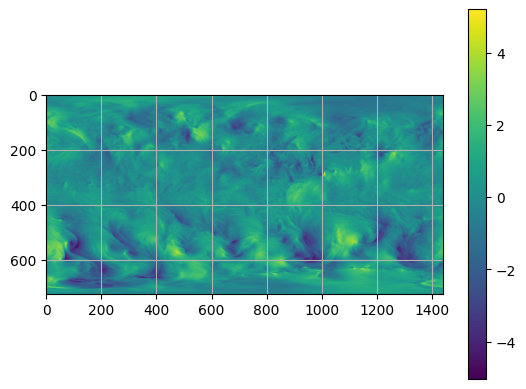

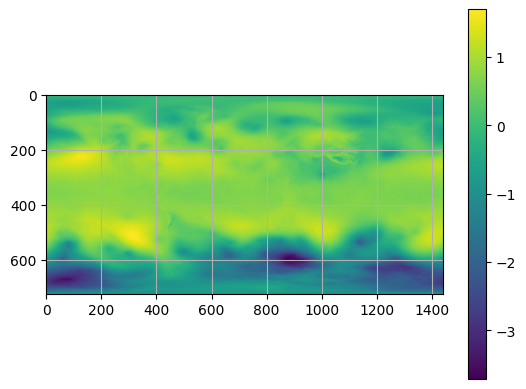

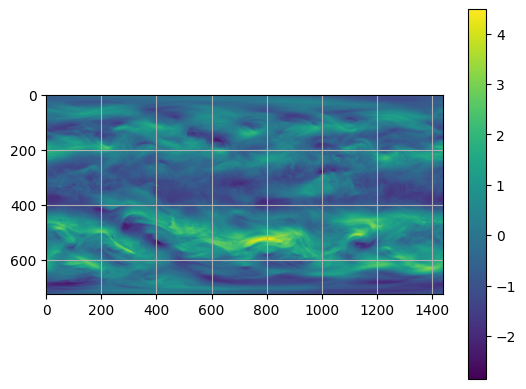

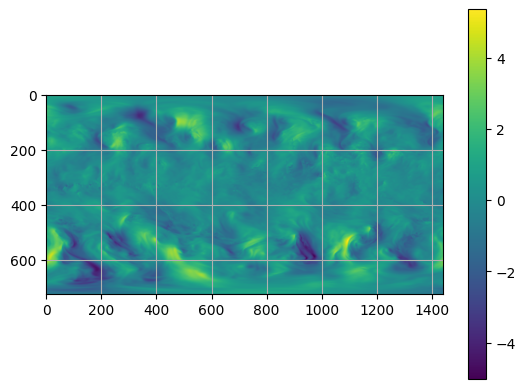

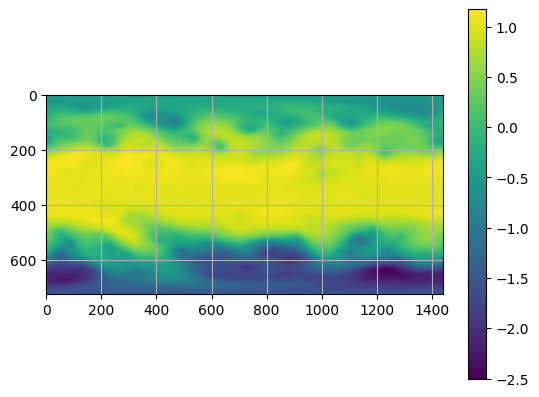

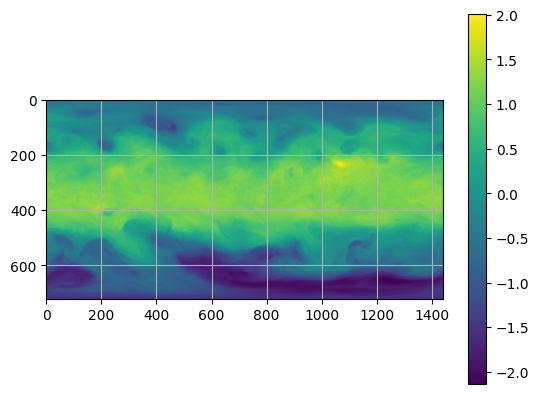

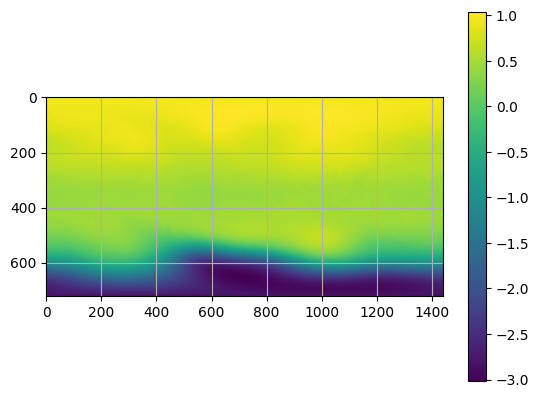

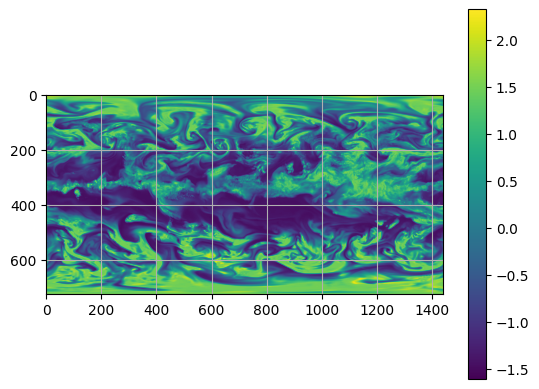

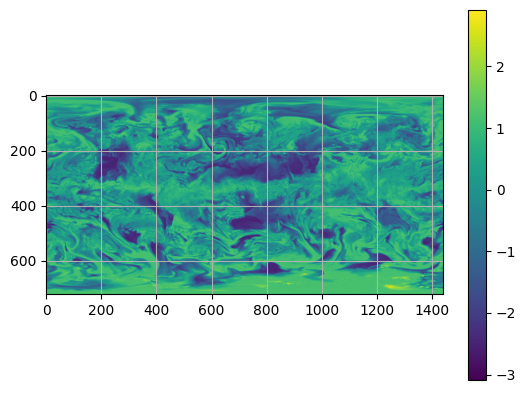

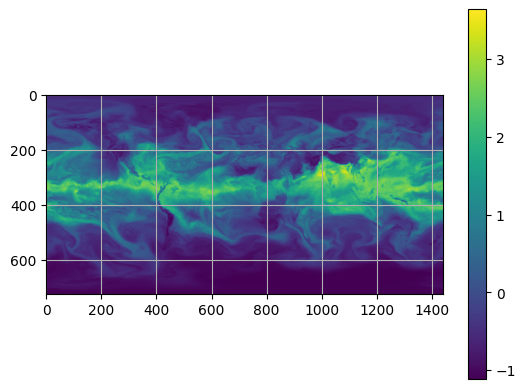

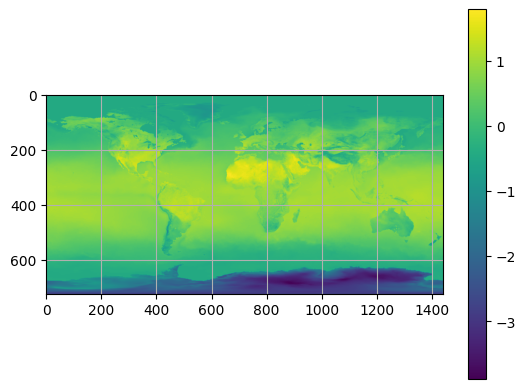

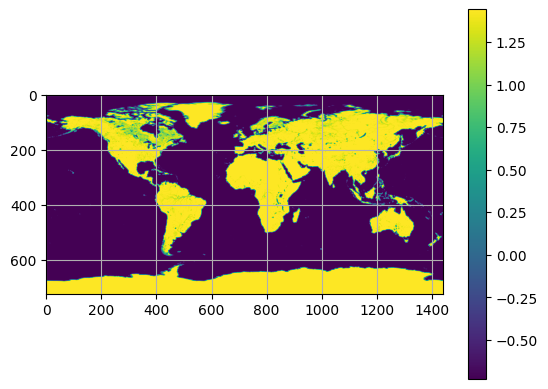

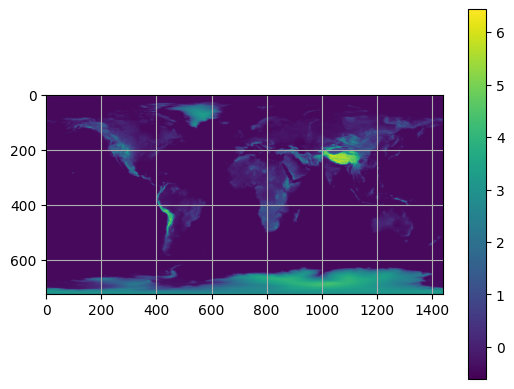

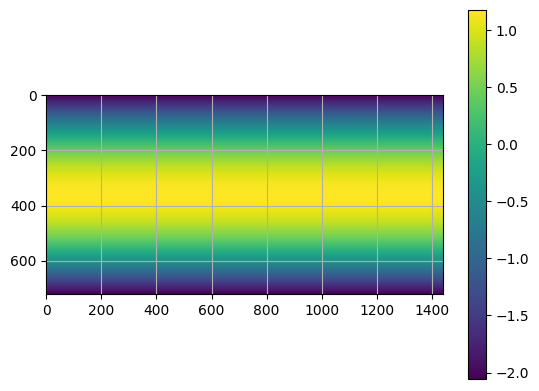

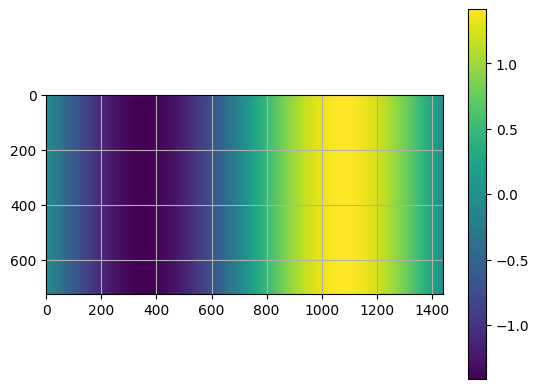

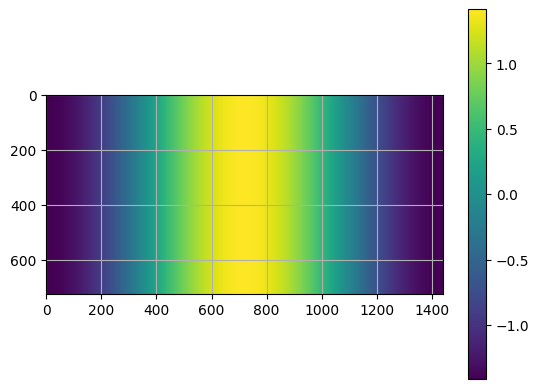

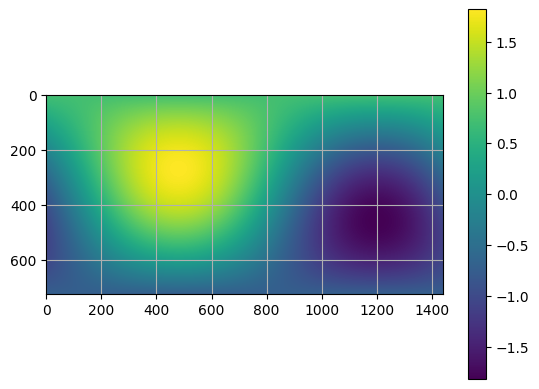

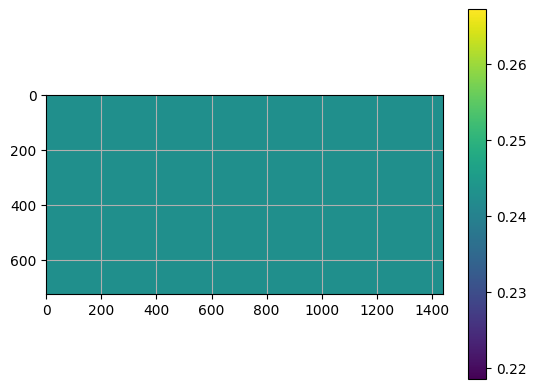

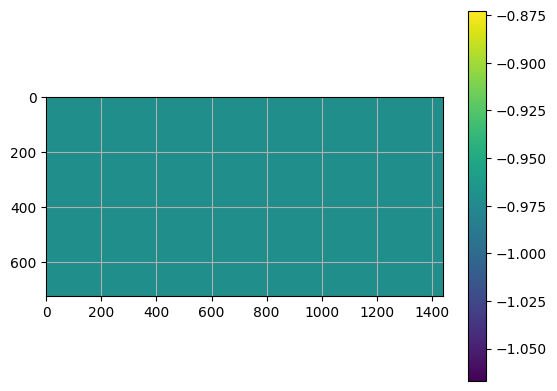

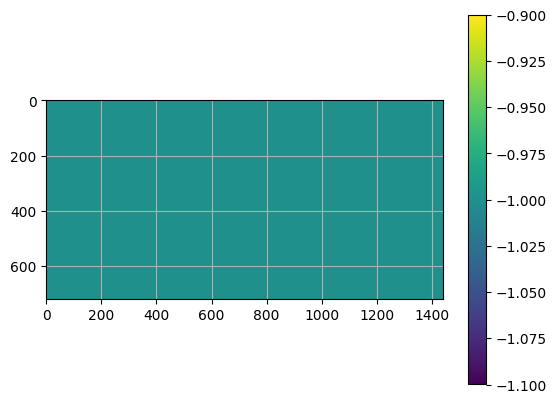

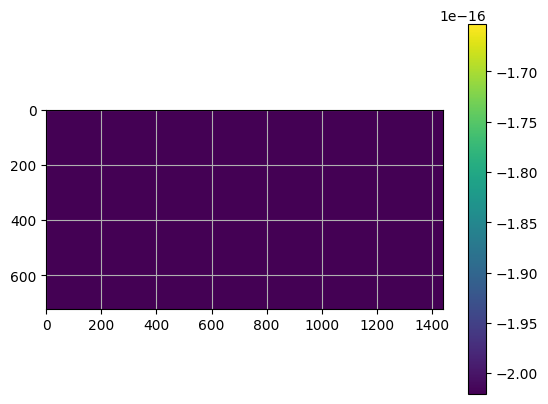

In [10]:
d = data["input"].cpu().numpy()
print(d.shape)
for c in range(31):
    # plot 2d image
    import matplotlib.pyplot as plt
    im = plt.imshow(d[0, 0, c, :, :])
    plt.grid(True)
    plt.colorbar(im)
    plt.show()
